In [2]:
import numpyro
#numpyro.set_platform("cpu")
import jax
import jax.numpy as jnp
import jax.random as jr 
import numpyro.distributions as dist

from numpyro.infer import SVI, Trace_ELBO, Predictive
from numpyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

from typing import Tuple, List, Callable
import sys
sys.path.append("../")
from utils import sample_training_points_space_filling

In [15]:
data = jnp.load('oscilator1_data.npy', allow_pickle=True).item()
X, Y, Y_f = data['X'], data['Y'], data['Y_f']

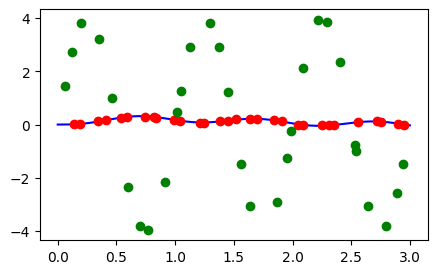

In [17]:
# Sample training points
X_u, u_train , X_f, f_train, X_test, u_test, f_test = sample_training_points_space_filling(X, Y, Y_f, 30, seed=0)

# Plot the sampled training points
plt.figure(figsize=(5, 3))
plt.plot(X, Y, 'b', label='Y')
plt.plot(X_u, u_train, 'ro', label='Y samples')
plt.plot(X_f, f_train, 'go', label='Y_f')
#plt.plot(X_f_samples, Y_f_samples, 'go', label='Y_f samples')
#plt.legend()

X_train = (X_u, X_f)
Y_train = (u_train, f_train)

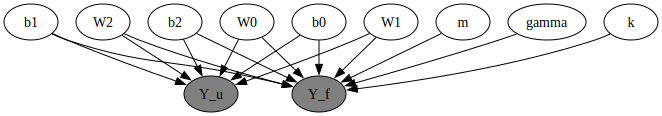

In [18]:
def dense_layer(
        i: int,
        size: List[int],
):  
    #Xavier initialization
    alpha_sq = 2/(size[0] + size[1])
    alpha_sq = 1.0
    W = numpyro.sample(f"W{i}", dist.Normal(0, alpha_sq**0.5).expand(size))
    b = numpyro.sample(f"b{i}", dist.Normal(0, alpha_sq**0.5).expand((size[-1],)))
    return W, b

def forward(
        W: List[jax.Array],
        b: List[jax.Array],
        X: jax.Array,
        activation: Callable,
):
    #input layer
    z = activation(jnp.dot(X, W[0]) + b[0])

    #hidden layers
    for i in range(1, len(W) - 1):
        z = activation(jnp.dot(z, W[i]) + b[i])

    #output layer with no activation
    z = jnp.dot(z, W[-1]) + b[-1]
    return z.squeeze()

def physics_forward(
        W: List[jax.Array],
        b: List[jax.Array],
        X: jax.Array,
        activation: Callable,
):
    #input layer
    u = partial(forward, W, b, activation=activation)
    u_prime = jax.grad(u)
    u_double_prime = jax.grad(u_prime)

    #vectorize the functions
    u_prime = jax.vmap(u_prime)(X)
    u_double_prime = jax.vmap(lambda x: u_double_prime(x.squeeze()))(X)
    return u_prime, u_double_prime[:, None]

def wideband_dnn(
        X: jax.Array,
        Y: jax.Array,
        layers: List[int],
):
    X_u, X_f = X
    
    if Y is not None:
        Y_u, Y_f = Y
    else:
        Y_u, Y_f = None, None

    N, input_dim = X_u.shape
    activation = jnp.tanh
    W = []
    b = []
    #build the layers with the given list
    for i, layer in enumerate(layers):
        W_, b_ = dense_layer(i, [input_dim, layer])
        W.append(W_)
        b.append(b_)
        input_dim = layer
    #forward pass through the network
    z = forward(W, b, X_u, activation)[:, None]

    dz, ddz = physics_forward(W, b, X_f, activation)
    assert dz.shape == z.shape, f"dz shape {dz.shape} does not match z shape {z.shape}"
    assert ddz.shape == z.shape, f"ddz shape {ddz.shape} does not match z shape {z.shape}"

    m = numpyro.sample(r"m", dist.Uniform(0, 2.))
    gamma = numpyro.sample(r"gamma", dist.Uniform(1, 3.))
    k = numpyro.sample(r"k", dist.Uniform(1, 3.))

    if Y is not None:
        assert Y_u.shape == z.shape , f"Y shape {Y_u.shape} does not match z shape {z.shape}"

    #precision_obs_u = numpyro.sample(r"observation precision", dist.Gamma(2., 1.))
    #sigma_obs_u = 1.0 / jnp.sqrt(precision_obs_u)   
    sigma_obs_u = 0.01

    #precision_obs_f = numpyro.sample(r"observation precision f", dist.Gamma(2., 1.))
    #sigma_obs_f = 1.0 / jnp.sqrt(precision_obs_f)
    sigma_obs_f = 0.01
    #oscillator equation
    f = m * ddz + gamma * dz + k * z

    #likelihood
    numpyro.sample(
        r"Y_u", 
        dist.Normal(z, sigma_obs_u).to_event(1), 
        obs=Y_u
    )
    numpyro.sample(
        r"Y_f", 
        dist.Normal(f, sigma_obs_f).to_event(1), 
        obs=Y_f
    )





LAYERS = [30, 30, 1]

try:
    render = numpyro.render_model(wideband_dnn, (X_train, Y_train, LAYERS))
except:
    render = None
    print("Module not installed. (pip install graphviz), (sudo apt-get install graphviz)")
render

In [19]:
from numpyro.infer import NUTS, MCMC
inf_key = jax.random.PRNGKey(0)
mcmc = MCMC(NUTS(wideband_dnn), num_warmup=1000, num_samples=1000)
mcmc.run(inf_key, X_train, Y_train, LAYERS)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [02:11<00:00, 15.25it/s, 1023 steps of size 6.47e-09. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   W0[0,0]      1.40      0.00      1.40      1.40      1.40      0.50      1.00
   W0[0,1]      0.63      0.00      0.63      0.63      0.63      0.50      1.00
   W0[0,2]     -0.87      0.00     -0.87     -0.87     -0.87      0.50      1.00
   W0[0,3]     -0.69      0.00     -0.69     -0.69     -0.69      0.50      1.00
   W0[0,4]     -1.62      0.00     -1.62     -1.62     -1.62      0.50      1.00
   W0[0,5]     -1.14      0.00     -1.14     -1.14     -1.14      0.50      1.00
   W0[0,6]     -0.18      0.00     -0.18     -0.18     -0.18      0.50      1.00
   W0[0,7]      1.38      0.00      1.38      1.38      1.38      0.50      1.00
   W0[0,8]     -1.81      0.00     -1.81     -1.81     -1.81      0.50      1.00
   W0[0,9]     -0.91      0.00     -0.91     -0.91     -0.91      0.50      1.00
  W0[0,10]     -1.22      0.00     -1.22     -1.22     -1.22      0.50      1.00
  W0[0,11]      0.12      0

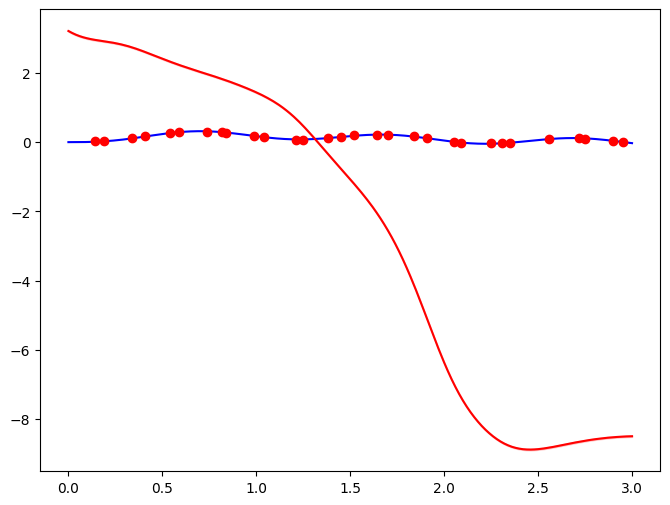

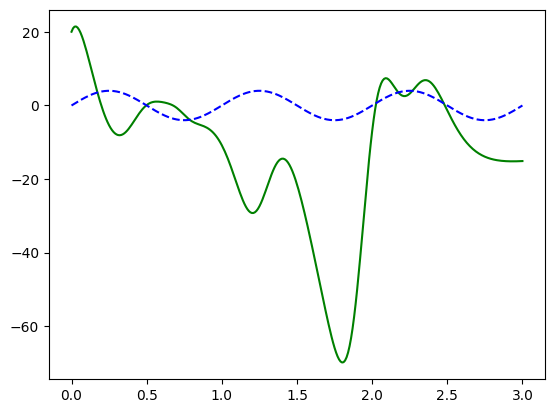

In [20]:
samples = mcmc.get_samples()
#predictive
predictive = Predictive(wideband_dnn, samples, return_sites=["Y_u", "Y_f"])
predictions = predictive(jax.random.PRNGKey(1), (X_test, X_test), None, LAYERS)

# Plot the sampled training points
plt.figure(figsize=(8, 6))
plt.plot(X, Y, 'b', label='Y')
plt.plot(X_train[0], Y_train[0], 'ro', label='Y samples')

# Plot the predictions
mean_prediction = jnp.mean(predictions["Y_u"], axis=0)
stddev_prediction = jnp.std(predictions["Y_u"], axis=0)

plt.fill_between(X_test.ravel(), mean_prediction.ravel() - 2*stddev_prediction.ravel(), mean_prediction.ravel() + 2*stddev_prediction.ravel(), color='r', alpha=0.2)
plt.plot(X_test, mean_prediction, 'r', label='Predictive mean')
#plot gamma distribution


#plot f
mean_prediction = jnp.mean(predictions["Y_f"], axis=0)
stddev_prediction = jnp.std(predictions["Y_f"], axis=0)
plt.figure()
plt.plot(X_test, mean_prediction, 'g', label='Predictive mean f')
plt.plot(X_test, f_test, 'b--', label='f--')



